This notebook aims to simulate a data scientist consuming data from a data pipeline, using PySpark. 

In this notebook, I will be executing the following steps:
  - Conduct EDA on data produced from Medallion Data Pipeline (Missing Values, Identifying Distributions and Relationships etc)
  - Deal with Multicollinearity 
  - Feature Selection & Transformation, Standardisation, Dimensionality Reduction 
  - Dealing with Dataset Imbalance

# 1. Import Libraries

In [21]:
# Import function to start Spark
from init_spark import start_spark
spark = start_spark()

from pyspark.sql.functions import (
    col, when, count, desc, isnan, isnull, lit, length, trim, lower, upper, to_date, concat_ws,  regexp_extract, sum 
)

from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, IntegerType, DateType, NumericType
)

25/06/30 22:22:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# 2. EDA: Summary Statistics & Identify Data Issues

In this section, I will be acting as a data scientist (credit risk modeling) pulling data from the Gold Delta Layer of the Medallion Structure. I will be mainly observing summary statistics, spotting and solving issues (e.g. missing values), understanding distribution of features etc. [](url)


In [22]:
df = spark.read.format("delta")\
    .load("../data/gold/medallion_cleaned_lc_data")
    
df.limit(10).toPandas()
    

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,44107057,NaN,11500.0,11500.0,11500.0,60,18.25,293.60,E,E1,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
1,47038475,NaN,12000.0,12000.0,12000.0,36,6.92,370.09,A,A4,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
2,44613469,NaN,32000.0,32000.0,32000.0,60,13.99,744.42,C,C4,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
3,43570106,NaN,17000.0,17000.0,17000.0,60,10.99,369.54,B,B4,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
4,44986522,NaN,4375.0,4375.0,4375.0,36,16.55,155.01,D,D2,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
5,44756975,NaN,1000.0,1000.0,1000.0,36,9.99,32.27,B,B3,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
6,43370547,NaN,6300.0,6300.0,6300.0,36,12.29,210.13,C,C1,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
7,44956266,NaN,7000.0,7000.0,7000.0,36,6.92,215.89,A,A4,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
8,44723575,NaN,6000.0,6000.0,6000.0,36,13.99,205.04,C,C4,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
9,46673650,NaN,14900.0,14900.0,14900.0,36,14.65,513.97,C,C5,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN


In [23]:
df.summary().toPandas()

25/06/30 22:23:16 WARN DAGScheduler: Broadcasting large task binary with size 1540.1 KiB


,summary,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term
0,count,2246857,0,2246857,2246857,2246857,2246857,2246857,2246857,2246857,...,10825,8572,10825,10825,2246857,2246857,34092,34092,34092,34092
1,mean,8.040004416338468E7,None,15054.386527491513,15049.364156241363,15034.384517157418,42.91265354225926,13.07994297814798,445.94291922898583,None,...,None,453.66880191320547,11627.343608314071,194.06692193995394,None,None,None,5008.302388243571,47.77877918573316,13.19538308107474
2,stddev,4.493433940020886E7,None,9186.763696700935,9184.889227266003,9186.411201678435,10.86825462480814,4.830367264745493,267.00915276872894,None,...,None,374.4646881647189,7618.116576905524,198.5177164077724,None,None,None,3690.3567965889756,7.309129781984291,8.157522588154121
3,min,54734,None,500.0,500.0,0.0,36,5.31,4.93,A,...,Current,1.92,55.73,0.01,Cash,N,ACTIVE,44.21,0.2,0.0
4,25%,45294193,None,8000.0,8000.0,8000.0,36,9.49,252.0,None,...,None,174.96,5627.73,44.69,None,None,None,2208.0,45.0,6.0
5,50%,84565040,None,12975.0,12950.0,12850.0,36,12.62,378.2,None,...,None,352.32,10017.41,133.29,None,None,None,4146.0,45.0,14.0
6,75%,122369309,None,20000.0,20000.0,20000.0,60,15.99,593.34,None,...,None,618.03,16112.71,284.15,None,None,None,6848.95,50.0,18.0
7,max,145647287,None,40000.0,40000.0,40000.0,60,30.99,1719.83,G,...,Late (31-120 days),2680.89,40306.41,1407.86,DirectPay,Y,COMPLETE,33601.0,521.35,181.0


Based on the summary statistics of the Lending Club dataset, several data quality issues become apparent. 
- Some columns are unusable, due to to having a **large percentage of missing values** (taken reference from `../sandbox/string_issues`)

- A number of features exhibit **missing values**, including `emp_length` etc. This requires imputation strategies to be implemented

- Some columns are irrelevant to our credit risk modeling project, due to **high cardinality** (large number of unique values), e.g. `emp_title` **(categorical data)**. 

- There are also **redundant columns**, like `member_id`, which provides no value to our prediction of LGD, EAD and PD.

- There are also **post-loan information**. This means that the value of these features are generated after loan origination (attaining application and approval). Hence, such features should be dropped, since they would skew our subsequent machine learning models. Such features include `total_pymnt`, `last_pymnt_d`

- There are features like `delinq_2yrs` which have **outliers** (maximum data point way above the 75% quartile)


# 3. EDA: Feature Handling 

Based on the above issues identified by me with the Lending Club Dataset, I will now be tackling each of them in order. 

### 3.1 Find Null Value % Per Column 
For this credit risk modeling project, I will be dropping columns with &gt; 50% missingness.  Many credit risk modelling projects on Kaggle and Github use 50%-65% missingness as the threshold to drop columns as well. 

However, let's display the columns which have >=50% missing values first to inspect them 

In [24]:

# Get total number of rows
total_rows = df.count()

# Calculate % of nulls per column and keep only those ≥ 50%
missing_val_threshold = 30

high_missingness_columns = []

for column in df.columns:
    null_count = df.select(sum(col(column).isNull().cast("int"))).collect()[0][0]
    null_pct = (null_count / total_rows) * 100
    if null_pct >= missing_val_threshold:
        print(f"{column}: {null_pct:.2f}% null")
        high_missingness_columns.append(column)

# Drop columns with >= 50% missing values (Low predictive power upon inspection)
df = df.drop(*high_missingness_columns) 
print("\n✅ Columns with high pct of missing values dropped ... \n")

# Inspect Dimensions

num_rows = df.count()

num_cols = len(df.columns)

print(f"Updated Shape: ({num_rows}, {num_cols})")

member_id: 100.00% null
mths_since_last_delinq: 51.23% null
mths_since_last_record: 84.08% null
next_pymnt_d: 59.60% null
mths_since_last_major_derog: 74.25% null
annual_inc_joint: 94.73% null
dti_joint: 94.73% null
verification_status_joint: 94.95% null
open_acc_6m: 38.24% null
open_act_il: 38.24% null
open_il_12m: 38.24% null
open_il_24m: 38.24% null
mths_since_rcnt_il: 40.18% null
total_bal_il: 38.24% null
il_util: 47.21% null
open_rv_12m: 38.24% null
open_rv_24m: 38.24% null
max_bal_bc: 38.24% null
all_util: 38.24% null
inq_fi: 38.24% null
total_cu_tl: 38.24% null
inq_last_12m: 38.24% null
mths_since_recent_bc_dlq: 76.98% null
mths_since_recent_revol_delinq: 67.20% null
revol_bal_joint: 95.29% null
sec_app_fico_range_low: 95.29% null
sec_app_fico_range_high: 95.29% null
sec_app_earliest_cr_line: 95.29% null
sec_app_inq_last_6mths: 95.29% null
sec_app_mort_acc: 95.29% null
sec_app_open_acc: 95.29% null
sec_app_revol_util: 95.37% null
sec_app_open_act_il: 95.29% null
sec_app_num_rev_

### 3.3 Dropping Irrelevant/Redundant Columns 
This section implements the removal of **meaningless columns, features which has high cardinality (categorical data), features with little predictive value, e.g. `member_id`, `emp_title` etc, and post-loan features**. Including such features may lead to multicollinearity, and ultimately lead to low predictive power of our credit models. 

Reasons why I removed certain columns are as shown: 
- Columns with `inv`: Largely same as its subset, e.g. `total_pymnt_inv` is largely the same as `total_pymnt`

- `last_pymnt_d` and `last_credit_pull_d` (according to Data Dictionary) have little predictive value even after feature engineering. It merely shows the last payment date by borrower and last date where credit report is pulled. This has little value in predicting PD, LGD or EAD. 

- `sub_grade` is more granular than `grade`. This may lead to a risk of overfitting of our PD, LGD, and EAD models. 

- High Cardinality Columns may lead to high computational costs in encoding for machine learning models, which makes it undesirable in a big data space such as credit risk. 

- Hardship & Settlement Features (Borrowers are only eligible for hardship and settlement programmes after loan origination for Lending Club, not when they apply for it). Borrowers will contact lenders of financial hardship, attempting to settle with lenders for interest-fee payments or lower principal sum payments. Such features should not be used to predict PD, LGD, and EAD. My models should not know if a borrower will fall into hardship for this credit risk modeling project 

- `disbursement_method` indicates how loan funds are delivered to the borrower. This has little relevance in predicting PD, LGD or EAD. 

- 🚩 Low Variance Features may lead to slower running of PCA (which aims to reduce dimensionality). They also add little value to prediction of PD, EAD and LGD. (Dealt after standardisation)


In [25]:
# Drop Derived/Meaningless Features 
derived_features = ["funded_amnt_inv", "sub_grade", "out_prncp_inv", "total_pymnt_inv", "last_pymnt_d", "last_credit_pull_d"] 
df = df.drop(*derived_features)
print(f"✅ Derived/Meaningless Features Dropped ...")


✅ Derived/Meaningless Features Dropped ...


In [26]:
# Drop High Cardinality Features 

# 1. Define Threshold 
high_cardinality_threshold = 50

# 2. Find Categorical Features (to identify high cardinality columns)


categorical_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
print(categorical_cols)

# 3. Identify high-cardinality columns
high_card_cols = []

for col_name in categorical_cols:
    unique_count = df.select(col_name).distinct().count()

    if unique_count >= high_cardinality_threshold:
        print(f"\n{col_name} has {unique_count} unique values → dropping ... ")
        high_card_cols.append(col_name)

# 4. Drop high cardinality columns
df = df.drop(*high_card_cols)

print(f"\n✅ High Cardinality Features Dropped ...")

['grade', 'emp_title', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']

emp_title has 480536 unique values → dropping ... 

addr_state has 51 unique values → dropping ... 

✅ High Cardinality Features Dropped ...


In [27]:
# Drop hardship related columns & miscelleanous columns 
hardship_columns = ["hardship_flag", "disbursement_method", "debt_settlement_flag", 'policy_code']

df = df.drop(*hardship_columns)
print("✅ Hardship & miscelleneous columns dropped ...")

✅ Hardship & miscelleneous columns dropped ...


🚩 I will need to remove post-loan origination features later on for PD prediction. Post-loan origination features such as `recoveries` are needed for LGD, EAD prediction, but not for PD prediction. 

### 3.4 Impute Missing Values (Categorical & Numerical)
After removing unnecessary columns with little predictive power, we will proceed to impute missing values. We will first identify % missing values per column. 

For numerical columns, median values shall replace missing values, given how we haven't dealt with outliers yet. For categorical columns, mode categories shall be used to replace missing values. Such an approach is common and simplistic, though there are advanced imputation techniques like clustering. However, we shall not lose focus of learning about the credit risk modeling domain in this project. 

In [28]:
total_rows = df.count()

for column in df.columns: 
    null_count = df.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"{column}: {null_count} null values, {round(null_count/total_rows * 100,2)}% missing values.")

emp_length: 144735 null values, 6.44% missing values.
inq_last_6mths: 1 null values, 0.0% missing values.
collections_12_mths_ex_med: 54 null values, 0.0% missing values.
tot_coll_amt: 67219 null values, 2.99% missing values.
tot_cur_bal: 67219 null values, 2.99% missing values.
total_rev_hi_lim: 67219 null values, 2.99% missing values.
acc_open_past_24mths: 46992 null values, 2.09% missing values.
avg_cur_bal: 67219 null values, 2.99% missing values.
bc_open_to_buy: 70095 null values, 3.12% missing values.
bc_util: 70995 null values, 3.16% missing values.
chargeoff_within_12_mths: 54 null values, 0.0% missing values.
mo_sin_old_il_acct: 135497 null values, 6.03% missing values.
mo_sin_old_rev_tl_op: 67219 null values, 2.99% missing values.
mo_sin_rcnt_rev_tl_op: 67219 null values, 2.99% missing values.
mo_sin_rcnt_tl: 67219 null values, 2.99% missing values.
mort_acc: 46992 null values, 2.09% missing values.
mths_since_recent_bc: 68715 null values, 3.06% missing values.
mths_since_rec

In [29]:
# Loop over each column
for feature in df.schema.fields:
    col_name = feature.name
    dtype = feature.dataType

    if isinstance(dtype, StringType):
        mode_value = (
            df.groupBy( col(f"{col_name}")  )
            .count()
            .orderBy(col("count").desc()) 
            .first()[0]
        )

        df = df.fillna({f"{col_name}": mode_value})



    # Impute Numerical Columns with Median
    elif isinstance(dtype, IntegerType) or isinstance(dtype, DoubleType):
        if df.filter(   col(col_name).isNull()  ).count() > 0:
            median_val = df.approxQuantile(col_name, [0.5], 0.01)[0]
            df = df.fillna({col_name: median_val})

print('✅ Categorical Column Missing Values Filled!')
print('✅ Numerical Column Missing Values Filled!')




✅ Categorical Column Missing Values Filled!
✅ Numerical Column Missing Values Filled!


In [30]:
# Double check if there are any missing values before subsequent steps
total_rows = df.count()

output_arr = []
for column in df.columns: 
    null_count = df.filter(col(column).isNull()).count()
    if null_count > 0:
        output_arr.append(f"{column}: {null_count} null values, {round(null_count/total_rows * 100,2)}% missing values.")

if len(output_arr) == 0: 
    print('✅ No Missing Values Found!')
else:
    print(output_arr)

✅ No Missing Values Found!


In [31]:
df_filled_missing = df

### 3.5 Handling Outliers 

It is important to handle outliers since they create skewed distributions, which can distort credit risk models.

They can dominate learning, causing bias or overfitting. 

But in credit risk, it is important to note that some outliers (e.g., bankrupted borrowers) are important signals. Such outliers should not be blindly trimmed. 

We will first be using `approxQuantile()` method, which is a relatively more computational effective way to identify outliers for big data. This shall be used in computing the % of outliers per numerical column. 

In [32]:
def percent_outliers(df, col_name, lower_pct=0.25, upper_pct=0.75):
    # 1. Compute percentile bounds
    quantiles = df.approxQuantile(col_name, [lower_pct, upper_pct], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1 

    # 2. Obtain lower and upper bound, any data points outside of this are seen as outliers 
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    total_rows = df.count()

    return df.filter( (col(col_name) < lower_bound) | (col(col_name) > upper_bound) ).count() / total_rows * 100

# 1. After cleaning missing values, find % outliers per column 
sample_df = df_filled_missing.sample(fraction=0.05, seed=42) # Efficiency 


outliers_dict = {}

for feature in sample_df.schema: 
    col_name = feature.name 
    data_type = feature.dataType

    if isinstance(data_type, (DoubleType, IntegerType)): 
        outlier_pct = percent_outliers(sample_df, col_name) 
        if outlier_pct > 0: 
            outliers_dict[col_name] = outlier_pct
            print(f"{col_name}: {round(outlier_pct,2) }% ")


loan_amnt: 1.55% 
funded_amnt: 1.55% 
int_rate: 2.6% 
installment: 3.52% 
annual_inc: 4.94% 
dti: 0.93% 
delinq_2yrs: 18.66% 
fico_range_low: 3.4% 
fico_range_high: 3.4% 
inq_last_6mths: 4.09% 
open_acc: 3.74% 
pub_rec: 15.8% 
revol_bal: 6.42% 
total_acc: 1.75% 
out_prncp: 10.29% 
total_pymnt: 4.01% 
total_rec_prncp: 4.03% 
total_rec_int: 7.72% 
total_rec_late_fee: 3.87% 
recoveries: 8.18% 
collection_recovery_fee: 7.82% 
last_pymnt_amnt: 14.99% 
last_fico_range_high: 4.39% 
last_fico_range_low: 4.39% 
collections_12_mths_ex_med: 1.63% 
acc_now_delinq: 0.41% 
tot_coll_amt: 14.6% 
tot_cur_bal: 4.07% 
total_rev_hi_lim: 6.44% 
acc_open_past_24mths: 2.12% 
avg_cur_bal: 5.93% 
bc_open_to_buy: 9.15% 
bc_util: 0.0% 
chargeoff_within_12_mths: 0.77% 
delinq_amnt: 0.34% 
mo_sin_old_il_acct: 5.3% 
mo_sin_old_rev_tl_op: 3.49% 
mo_sin_rcnt_rev_tl_op: 8.12% 
mo_sin_rcnt_tl: 6.58% 
mort_acc: 4.24% 
mths_since_recent_bc: 9.07% 
mths_since_recent_inq: 5.34% 
num_accts_ever_120_pd: 22.4% 
num_actv_bc_tl

Now, we can define concrete rules on how I should deal with outliers. Rules are as shown below: 
- **Very few outliers (1 - 2%)**: Trim / Drop rows 
- **Few Outliers & Outliers are Valid but Extreme Entries**: Winsorise (Cap values)

- **High % Outliers**: Likely to be heavily right-skewed (to be transformed later on)

The goal of dropping and winsorizing is to ensure % of outliers remain slightly below 5%. To ensure these records do not skew our credit risk models, they will be transformed later on. 

In [33]:
# 2. Save df to df1 before dealing with outliers 
df1 = df_filled_missing

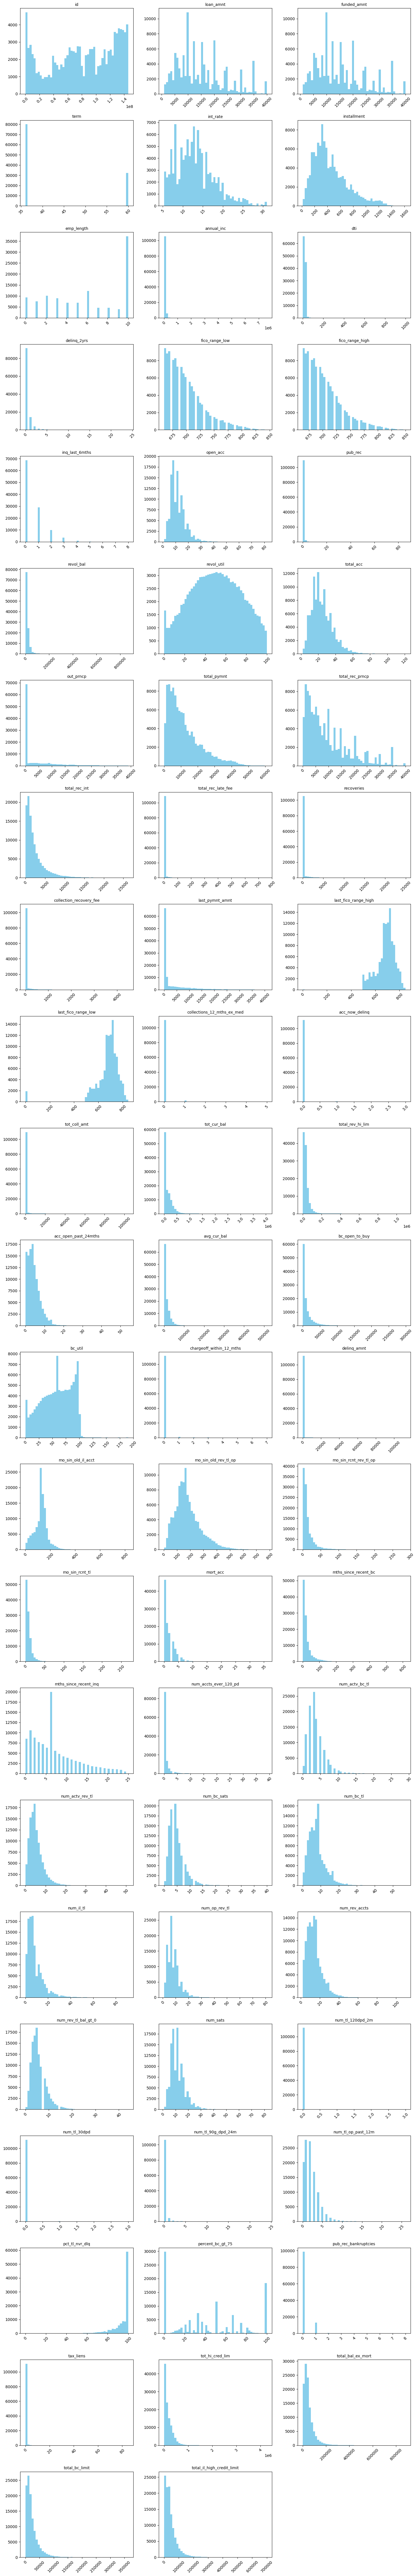

In [38]:
# 5. Check distribution for all numerical columns 
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import NumericType

# 1. Select numerical columns
numeric_cols = [field.name for field in df.schema if isinstance(field.dataType, NumericType)]

# 2. Sample small portion of data (e.g., 5%) and convert to pandas
sample_df2 = df_filled_missing.select(numeric_cols).sample(fraction=0.05, seed=42)
sample_pdf = sample_df2.toPandas()

# 3. Plot histograms as subplots
n_cols = 3  # Number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_cols):
    axes[i].hist(sample_pdf[col_name].dropna(), bins=50, color='skyblue')
    axes[i].set_title(col_name, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [34]:

# 3. Perform trimming & winsorisation 
def winsorize_column(df, col_name, lower_pct=0.25, upper_pct=0.75):
    # Get lower and upper bounds
    bounds = df.approxQuantile(col_name, [lower_pct, upper_pct], 0.01)
    lower, upper = bounds[0], bounds[1]

    # Apply winsorization
    return df.withColumn(
        col_name,  
        when(col(col_name) < lower, lower)
        .when(col(col_name) > upper, upper)
        .otherwise(col(col_name))
    )

# Debug: ensure dictionary is not empty
print(f"🧮 Total columns with outliers: {len(outliers_dict)}\n")

# Iterate over each column in outliers_dict
for col_name in outliers_dict.keys(): 
    pct = outliers_dict[col_name]

    if 0 < pct <= 1:
        print(f"✅ Dropping rows with outliers in {col_name} ({round(pct, 2)}%) ...")
        q1, q3 = df1.approxQuantile(col_name, [0.25, 0.75], 0.01)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df1 = df1.filter((col(col_name) >= lower) & (col(col_name) <= upper))

    elif 1 < pct <= 5:
        print(f"✅ Winsorizing {col_name} ({round(pct, 2)}%) ...")
        df1 = winsorize_column(df1, col_name)

    else:
        print(f"🚩 Skipping {col_name} ({round(pct, 2)}%) — too many outliers ...")



🧮 Total columns with outliers: 63

✅ Winsorizing loan_amnt (1.55%) ...
✅ Winsorizing funded_amnt (1.55%) ...
✅ Winsorizing int_rate (2.6%) ...
✅ Winsorizing installment (3.52%) ...
✅ Winsorizing annual_inc (4.94%) ...
✅ Dropping rows with outliers in dti (0.93%) ...
🚩 Skipping delinq_2yrs (18.66%) — too many outliers ...
✅ Winsorizing fico_range_low (3.4%) ...
✅ Winsorizing fico_range_high (3.4%) ...
✅ Winsorizing inq_last_6mths (4.09%) ...
✅ Winsorizing open_acc (3.74%) ...
🚩 Skipping pub_rec (15.8%) — too many outliers ...
🚩 Skipping revol_bal (6.42%) — too many outliers ...
✅ Winsorizing total_acc (1.75%) ...
🚩 Skipping out_prncp (10.29%) — too many outliers ...
✅ Winsorizing total_pymnt (4.01%) ...
✅ Winsorizing total_rec_prncp (4.03%) ...
🚩 Skipping total_rec_int (7.72%) — too many outliers ...
✅ Winsorizing total_rec_late_fee (3.87%) ...
🚩 Skipping recoveries (8.18%) — too many outliers ...
🚩 Skipping collection_recovery_fee (7.82%) — too many outliers ...
🚩 Skipping last_pymnt_a

In [35]:
# 4. Check for outlier % again 
sample_df1 = df1.sample(fraction=0.05, seed=42) # Efficiency 

for feature in df1.schema: 
    col_name = feature.name 
    data_type = feature.dataType

    if isinstance(data_type, (DoubleType, IntegerType)): 
        outlier_pct = percent_outliers(df1, col_name) 
        if outlier_pct > 0: 
            print(f"{col_name}: {round(outlier_pct,2) }% ")

dti: 0.02% 
delinq_2yrs: 17.88% 
pub_rec: 15.92% 
revol_bal: 6.18% 
out_prncp: 9.86% 
total_rec_int: 7.65% 
recoveries: 8.19% 
collection_recovery_fee: 7.82% 
last_pymnt_amnt: 13.86% 
tot_coll_amt: 14.85% 
total_rev_hi_lim: 6.09% 
avg_cur_bal: 5.86% 
bc_open_to_buy: 8.77% 
bc_util: 0.0% 
mo_sin_old_il_acct: 5.48% 


mo_sin_rcnt_rev_tl_op: 7.43% 
mo_sin_rcnt_tl: 6.67% 


mths_since_recent_bc: 9.64% 


mths_since_recent_inq: 3.09% 


num_accts_ever_120_pd: 21.75% 


num_tl_90g_dpd_24m: 4.56% 
pct_tl_nvr_dlq: 7.17% 
pub_rec_bankruptcies: 12.12% 


total_bal_ex_mort: 6.06% 


total_bc_limit: 6.11% 
total_il_high_credit_limit: 5.34% 


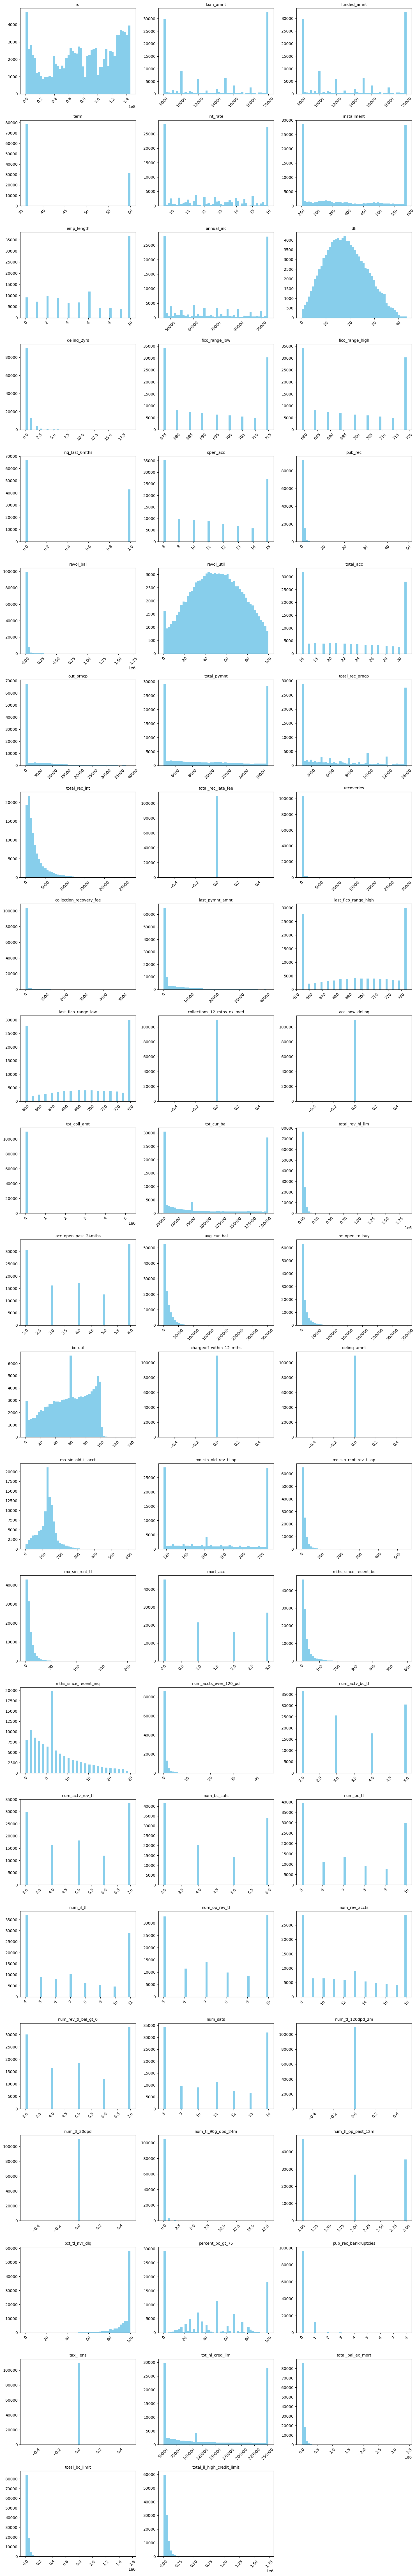

In [36]:
# 5. Check distribution for all numerical columns 
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import NumericType

# 1. Select numerical columns
numeric_cols = [field.name for field in df.schema if isinstance(field.dataType, NumericType)]

# 2. Sample small portion of data (e.g., 5%) and convert to pandas
sample_df2 = df1.select(numeric_cols).sample(fraction=0.05, seed=42)
sample_pdf = sample_df2.toPandas()

# 3. Plot histograms as subplots
n_cols = 3  # Number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_cols):
    axes[i].hist(sample_pdf[col_name].dropna(), bins=50, color='skyblue')
    axes[i].set_title(col_name, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [37]:
df.limit(100).toPandas()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,44107057,11500.0,11500.0,60,18.25,293.60,E,6,RENT,25000.0,...,0.0,2.0,100.0,20.0,0.0,0.0,24200.0,10307.0,16300.0,0.0
1,47038475,12000.0,12000.0,36,6.92,370.09,A,6,RENT,53900.0,...,0.0,5.0,100.0,0.0,0.0,0.0,212844.0,79756.0,89700.0,36144.0
2,44613469,32000.0,32000.0,60,13.99,744.42,C,6,MORTGAGE,88000.0,...,0.0,1.0,80.0,100.0,0.0,0.0,36700.0,25736.0,17000.0,0.0
3,43570106,17000.0,17000.0,60,10.99,369.54,B,6,MORTGAGE,49378.8,...,0.0,2.0,100.0,100.0,0.0,0.0,193352.0,34738.0,16800.0,21052.0
4,44986522,4375.0,4375.0,36,16.55,155.01,D,6,MORTGAGE,48180.0,...,0.0,3.0,71.0,66.7,1.0,0.0,19824.0,4318.0,3750.0,15374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45534910,17400.0,17400.0,36,12.29,580.35,C,6,MORTGAGE,39684.0,...,0.0,1.0,93.1,60.0,0.0,0.0,161013.0,52933.0,32700.0,46762.0
96,43956708,4200.0,4200.0,36,14.65,144.88,C,6,MORTGAGE,50000.0,...,0.0,0.0,96.0,83.3,1.0,0.0,168220.0,45459.0,11900.0,52920.0
97,44087120,25000.0,25000.0,60,14.65,590.17,C,6,MORTGAGE,61000.0,...,0.0,4.0,95.2,37.5,0.0,0.0,113900.0,29191.0,41800.0,0.0
98,44329959,9000.0,9000.0,36,10.99,294.61,B,6,OWN,48700.0,...,0.0,1.0,91.7,50.0,1.0,1.0,76650.0,7383.0,5800.0,4550.0


### 3.6 Peform Feature Transformation (Skewness)
We will group the following numerical features into the following categories: 
- **Weird Bimodal Distributions**: Avoid over-transforming them since this reflects real-world extreme borrowers' behaviour / demographics
- **Highly Right Skewed (Continuous)**: Perform log transformation (if skewness issue is unsolved, utilise Box-Cox)
- **Highly Right Skewed (Pct / Probability)**: Logit Transformation
- **Left Skewed Variables**: Use Power / Exponential Transformations
- **Already Categorical**: Features such as `term` are already discrete by nature, and should not be transformed, at most encoded 

## 3. Multicollinearity Handling

## 4. Feature Selection & Engineering 

### Low Variance Filter

### Save as Master Features 


